# Bayesian Linear Regression
Created by: Eunhyuk Shin\
Contact: silvershine157@kaist.ac.kr

# Preliminary
우선 사용할 라이브러리와 글로벌 파라미터, 시각화 함수들을 선언하겠습니다.

In [12]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# global parameters
X_SCALE = 3.0
W_SCALE = 3.0
BETA = 2. # = 1/sigma^2
W0_TRUE = -0.5
W1_TRUE = 0.8

def visualize_data(X, y):
    plt.scatter(X[:, 1], y, marker='.', color='k')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

def visualize_model(X, y, w_dict):
    plt.figure()
    ax = plt.subplot(1,2,1)
    x_line = np.array([-X_SCALE, X_SCALE])
    for key in w_dict:
        w = w_dict[key]
        y_line = w[1]*x_line + w[0]
        ax.plot(x_line, y_line, label=key)
    ax.scatter(X[:, 1], y, marker='.', color='k')
    ax.set_aspect(aspect=1.0)
    ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.axis([-X_SCALE, X_SCALE, -X_SCALE, X_SCALE])
    ax = plt.subplot(1,2,2)
    for key in w_dict:
        w = w_dict[key]
        ax.scatter(w[0], w[1], label=key)
    ax.set_aspect(aspect=1.0)
    ax.legend()
    ax.set_xlabel('w0')
    ax.set_ylabel('w1')
    ax.axis([-W_SCALE, W_SCALE, -W_SCALE, W_SCALE])
    plt.show()

def get_density(m, S):
    beta = 0.5
    W0 = np.linspace(-W_SCALE, W_SCALE)
    W1 = np.linspace(-W_SCALE, W_SCALE)
    W0, W1 = np.meshgrid(W0, W1)
    W = np.stack([W0, W1], axis=2) # (G, G, 2)
    S_det = np.linalg.det(S)
    S_inv = np.linalg.inv(S)
    normalizer = np.sqrt((((2*np.pi)**2))*S_det)
    fac = np.einsum('...k,kl,...l->...', W-m, S_inv, W-m) # (G, G)
    log_density = -fac/2.0 - np.log(normalizer)
    density = np.exp(log_density)
    return density

def visualize_bayesian(m, S):
    plt.figure()
    ax = plt.subplot(1,2,1)
    n_sampling = 50
    for _ in range(n_sampling):
        w = np.random.multivariate_normal(m, S)
        x_line = np.array([-X_SCALE, X_SCALE])
        y_line = w[1]*x_line + w[0]
        ax.plot(x_line, y_line, 'y--')
    ax.set_aspect(aspect=1.0)
    ax.axis([-X_SCALE, X_SCALE, -X_SCALE, X_SCALE])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax = plt.subplot(1,2,2)
    density = get_density(m, S)
    ax.imshow(np.flip(density, axis=0))
    G = density.shape[0]
    ax.set_xticks([0])
    ax.set_xticklabels([" "])
    ax.set_yticks([0])
    ax.set_yticklabels([" "])
    ax.set_xlabel('w0')
    ax.set_ylabel('w1')
    plt.show()

# Introduction

오늘 강의에서 배운 Bayesian inference의 개념을 직접 확인할 수 있는 Bayesian linear regression을 실습할 것입니다. 학습 단계는 다음과 같습니다.

- 인공 데이터셋을 이용하여 maximum likelihood 방법이 가지는 한계 확인하기
- Bayesian linear regression을 적용하여, posterior가 어떤 정보를 담는지 관찰하기

# Data

실험에 사용할 데이터셋을 인공적으로 만들겠습니다. 1D input $x$와 1D output $y$의 쌍이 여러개 주어져있는 데이터셋입니다.

In [13]:
def make_data(N):
    X1 = np.random.randn(N)
    X = np.stack([np.ones(N), X1], axis=1) # (N, 2)
    w_true = np.array([W0_TRUE, W1_TRUE]) # (1, 2)
    y = np.matmul(X, w_true.transpose()) + (1/np.sqrt(BETA))*np.random.randn(N) # (N, 1)
    return X, y, w_true

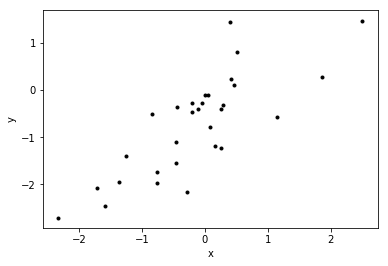

In [14]:
X, y, w_true = make_data(30)
visualize_data(X, y)

# Linear Model

1D input $x$와 1D output $y$의 쌍이 여러개 주어져있는 데이터셋을 분석하는 상황을 가정합시다.

$x$와 $y$의 관계를 분석하기 위해, 다음과 같이 Gaussian 노이즈가 있는 선형 모델을 사용합니다.

$y = w_0 + w_1 x + \epsilon$

$\epsilon \sim \mathcal{N}(0, \beta^{-1})$

이를 모델의 likelihood로 표현하면 다음과 같습니다. 편의를 위해 $\mathbf{x} = [1, x] \in \mathbb{R}^2$, $\mathbf{w} = [w_0, w_1] \in \mathbb{R}^2$로 두겠습니다.

$p(y|\mathbf{x}; \mathbf{w}) = \mathcal{N}(y;  \mathbf{w}^T \mathbf{x}, \beta^{-1})$

데이터 포인트가 $N$개 있을 때는 다음과 같습니다. 편의를 위해 $\mathbf{y} = [y_1, ..., y_N] \in \mathbb{R}^N$ , $\mathbf{X} = [\mathbf{x}_1, ..., \mathbf{x}_N] \in \mathbb{R}^{N \times 2}$로 두겠습니다.

$p(\mathbf{y}|\mathbf{X}; \mathbf{w}) = \prod_{i=1}^N \mathcal{N}(y_i;  \mathbf{w}^T \mathbf{x}_i, \beta^{-1})$

## Ground truth model

편의를 위해 인공데이터를 만드는데 사용된 ground truth 모델의 파라미터 $\mathbf{w}_{true}$가 변수 w_true에 담겨있습니다. 데이터와 함께 시각화해봅시다.

[-0.5  0.8]


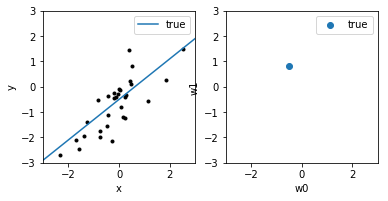

In [15]:
print(w_true)
visualize_model(X, y, {"true": w_true})

좌측 그림은 가로축이 $x$, 세로축이 $y$로, 아까 생성한 데이터와 함께 이를 생성한 ground truth 선형 모델이 직선으로 시각화되어있습니다.\
우측 그림은 가로축이 $w_0$, 세로축이 $w_1$으로 점 하나가 선형모델 하나에 해당합니다. 지금은 ground truth 선형 모델 하나가 점으로 찍혀있습니다.

# Maximum likelihood estimation

이제 관측 가능한 데이터인 X와 y만 있는 상황에서 $\mathbf{w}$값을 추정해봅시다.

대표적으로 사용되는 파라미터 추정방법에는 maximum likelihood estimation (MLE) 방법이 있습니다. 즉, 데이터의 likelihood를 최대화하는 모델을 찾는 것입니다.

$\mathbf{w}_{MLE} = \text{argmax}_{\mathbf{w}} p(\mathbf{y}; \mathbf{X}, \mathbf{w})$

우리가 가지고 있는 모델에 대한 MLE는 기본적인 least squares linear regression과 동치입니다.

$\mathbf{w}_{MLE} = \mathbf{w}_{LS} = \text{argmin}_{\mathbf{w}} || \mathbf{X} \mathbf{w} - \mathbf{y} ||_2^2 = (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$

위 식을 토대로 MLE 솔루션을 구현해봅시다. a.transpose(), np.linalg.inv()등을 이용할 수 있습니다.

In [16]:
def mle(X, y):
    '''
    X: (N, 2)
    y: (N,)
    ---
    w_mle: (2,)
    '''
    w_mle = None
    # Your code here: MLE
    XT = X.transpose()
    w_mle = np.matmul(np.linalg.inv(np.matmul(XT, X)), np.matmul(XT, y))
    return w_mle

이제 MLE를 이용하여 파라미터를 추정해봅시다

In [17]:
w_mle = mle(X, y)
print(w_mle)

[-0.59788566  0.85753606]


정확하게 추정이 되었는지 ground truth와 함께 시각화해봅시다.

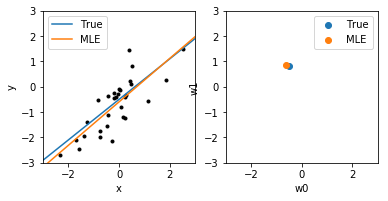

In [18]:
visualize_model(X, y, {"True": w_true, "MLE": w_mle})

MLE와 True가 어느정도 가깝게 나오는 것을 확인할 수 있습니다. 데이터가 많이 있을 때 MLE은 좋은 파라미터 추정 방법이 될 수 있습니다.\
하지만 적은 데이터가 주어질 때는 어떨까요? N=4로 두고 실험을 반복해봅시다.

[-0.5  0.8]
[-0.36069347  2.10394615]


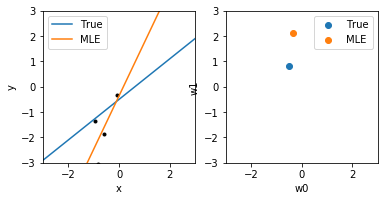

In [19]:
X, y, w_true = make_data(4)
w_mle = mle(X, y)
print(w_true)
print(w_mle)
visualize_model(X, y, {"True": w_true, "MLE": w_mle})

위 셀을 반복해서 실행하다보면, 어쩔 때는 정확하게 추정을 하지만 어쩔 때는 큰 오차로 추정이 빗나가기도 한다는 것을 알 수 있습니다. 이처럼 MLE는 데이터가 적을때 결과를 믿을 수 없다는 취약점이 있습니다.

# Bayesian inference

데이터가 적을 때는 필연적으로 불확실성이 발생하기 때문에, 이를 우리에게 알려줄 수 있는 추론 방법이 있는 것은 대단히 유용합니다.\
Bayesian inference에서는 파라미터 $\mathbf{w}$를 random variable로 취급하고, 그 확률분포를 '믿음의 정도'로 해석합니다. 분포가 넓게 퍼져있을 수록 불확실성이 크고, 분포가 좁게 모여있으면 불확실성이 적다는 것을 의미합니다.\
데이터 $\mathbf{D}$를 관찰하기 전의 파라미터에 대한 믿음을 prior 분포 $p(\mathbf{w})$로 모델링하고, 데이터를 관찰한 후에는 Bayes rule을 이용한 업데이트로 posterior 분포 $p(\mathbf{w}|\mathbf{D})$를 계산합니다.

$p(\mathbf{w}|\mathbf{D}) = \frac{p(\mathbf{D}|\mathbf{w})p(\mathbf{w})}{p(\mathbf{D})} $

## Prior

Likelihood를 Gaussian으로 잡았으므로, 파라미터에 대한 분포를 conjugate prior인 Gaussian으로 두겠습니다.

$p(\mathbf{w}) = \mathcal{N}(\mathbf{w}; \mathbf{m}_0, \mathbf{S}_0)$

데이터를 관찰하기 전에는 별다른 정보가 없으므로, unit Gaussian으로 두겠습니다.

$\mathbf{m}_0 = [0, 0]$, $\mathbf{S}_0 = I$

이 믿음을 토대로 상상할 수 있는 다양한 모델을 시각화하기 위해서, prior 분포에서 선형모델들을 여러번 뽑아보겠습니다.

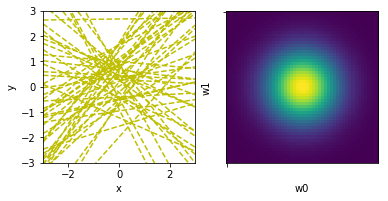

In [20]:
m0 = np.array([0, 0])
S0 = 1.0*np.eye(2)
visualize_bayesian(m0, S0)

좌측 이미지에는 뽑은 선형모델들이 중첩되어 시각화되어 있습니다. 아직 데이터를 관찰하기 전이기 때문에, 다양한 형태의 선형 모델에 대해 골고루 믿음이 분포해있습니다.\
우측 이미지에는 파라미터 공간에서 넓게 퍼져있는 prior 분포가 직접 시각화되어있습니다.

## Posterior

이제 데이터를 관측한 후에 파라미터에 대한 믿음을 업데이트해줄 차례입니다. 우리 모델에 Bayes rule을 적용하는 식은 다음과 같습니다. 유도 과정은 복잡하므로 생략하겠습니다.

Posterior 분포의 파라미터

$\mathbf{m_N} = \mathbf{S_N}(\mathbf{S_0}^{-1} \mathbf{m_0} + \beta \mathbf{X}^T \mathbf{y})$

$\mathbf{S_N}^{-1} = \mathbf{S_0}^{-1} + \beta \mathbf{X}^T \mathbf{X}$

Posterior 분포:

$p(\mathbf{w} | \mathbf{X}, \mathbf{y}) = \mathcal{N}(\mathbf{w}; \mathbf{m}_N, \mathbf{S}_N)$


위 식을 토대로 Bayesian 업데이트를 구현해봅시다. a.transpose(), np.linalg.inv()등을 이용할 수 있습니다.

In [40]:
def get_posterior(m0, S0, X, y):
    '''
    m0: (2,)
    S0: (2, 2)
    X: (N, 2)
    y: (N,)
    ---
    mN: (2,)
    SN: (2, 2)
    '''
    beta = BETA
    SN = None
    mN = None
    # Your code here: Bayesian update
    S0_inv = np.linalg.inv(S0)
    SN = np.linalg.inv(S0_inv + beta*np.matmul(X.transpose(), X))
    mN = np.matmul(SN, np.matmul(S0_inv, m0) + beta*np.matmul(X.transpose(), y))
    return mN, SN

적은 데이터를 생성하고, 이를 관측한 posterior를 계산하여 시각화해봅시다.

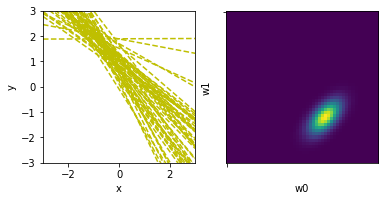

In [39]:
X, y, w_true = make_data(4)
mN, SN = get_posterior(m0, S0, X, y)
visualize_bayesian(mN, SN)

믿음의 범위가 좁혀지지만, 다양한 가능성에 대한 불확실성을 계속 유지하고 있다는 것을 볼 수 있습니다. Ground truth model과 비교해봅시다.

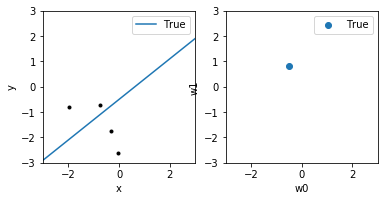

In [33]:
visualize_model(X, y, {"True": w_true})

이번엔 많은 데이터를 생성하고, posterior를 계산해봅시다.

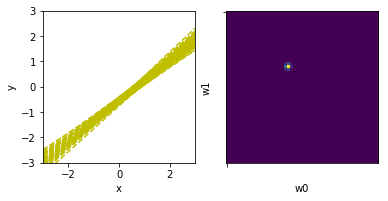

In [34]:
X, y, w_true = make_data(100)
mN, SN = get_posterior(m0, S0, X, y)
visualize_bayesian(mN, SN)

이 경우 모델에 대한 불확실성이 굉장히 낮아지게 됩니다. Ground truth와 비교해봅시다.

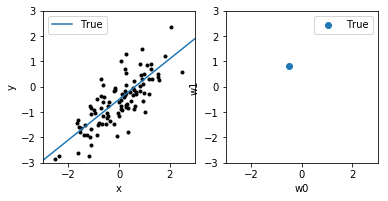

In [35]:
visualize_model(X, y, {"True": w_true})

# More experiments

데이터 세팅을 바꿔가며 자유롭게 ground truth, MLE, Bayesian linear regression을 비교해봅시다.

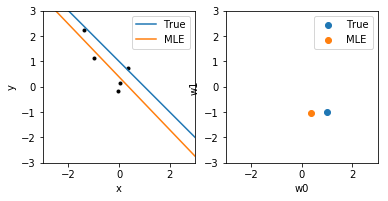

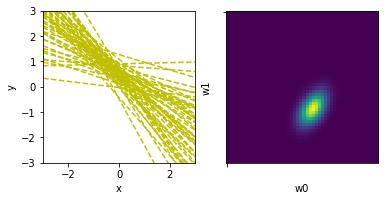

In [37]:
# global parameters
X_SCALE = 3.0
W_SCALE = 3.0
BETA = 2. # = 1/sigma^2
W0_TRUE = 1.0
W1_TRUE = -1.0

# run experiment
N = 5
X, y, w_true = make_data(N)
w_mle = mle(X, y)
visualize_model(X, y, {"True": w_true, "MLE": w_mle})
mN, SN = get_posterior(m0, S0, X, y)
visualize_bayesian(mN, SN)